In [46]:
from datetime import datetime
import time
from concurrent import futures 
import pandas as pd
import requests    

%matplotlib inline

In [13]:
end = datetime.now()
start = datetime(end.year - 1, end.month , end.day)

start_utc = time.mktime(start.timetuple())
end_utc = time.mktime(end.timetuple())

In [75]:
coins = ["ETH", "XRP", "FCT", "LTC", "BCHABC", "ATOM", "STR", "DASH", "XMR", "BCHSV", "DOGE", "EOS", "CLAM", "ETC"]

data = {}

for coin in coins:   
    data[coin] =  pd.DataFrame(requests.get(
        f"https://poloniex.com/public?command=returnChartData&currencyPair=BTC_{coin}"
        f"&start={start_utc}&end={end_utc}&period={30*60}"
    ).json())
    data[coin]['date'] = pd.to_datetime(data[coin]['date'], unit="s")
    data[coin].set_index('date', inplace=True)

In [76]:
data["ETH"].head()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2018-05-13 03:30:00,0.080746,0.080837,0.080374,0.080458,73.728215,5.952546,0.080736
2018-05-13 04:00:00,0.080630,0.080837,0.080540,0.080750,50.610591,4.082539,0.080666
2018-05-13 04:30:00,0.080365,0.080815,0.080365,0.080791,60.623373,4.886988,0.080612
2018-05-13 05:00:00,0.080470,0.080571,0.080287,0.080495,41.384609,3.326698,0.080385
2018-05-13 05:30:00,0.080505,0.080750,0.080470,0.080500,36.413598,2.936054,0.080631


In [77]:
import backtrader as bt
import numpy as np

In [113]:
def min_n(array, n):
    return np.argpartition(array, n)[:n]

def max_n(array, n):
    return np.argpartition(array, -n)[-n:]

class CrossSectionalMR(bt.Strategy):
    params = (
        ('n', 2),
    )
    def __init__(self):
        self.inds = {}
        for d in self.datas:
            self.inds[d] = {}
            self.inds[d]["pct"] = bt.indicators.PercentChange(d.close, period=100)
            self.inds[d]["std"] = bt.indicators.StandardDeviation(d.close, period=100)

    def prenext(self):
        self.next()

    def next(self):
        available = list(filter(lambda d: len(d) > 100, self.datas)) # only look at data that existed last week
        rets = np.zeros(len(available))
        stds = np.zeros(len(available))
        for i, d in enumerate(available):
            rets[i] = self.inds[d]['pct'][0]
            stds[i] = self.inds[d]['std'][0]

        
            
        market_ret = np.mean(rets)
        weights = -(rets - market_ret)
        max_weights_index = max_n(np.abs(weights), len(available) // self.params.n)
        low_volality_index = min_n(stds, len(available) // self.params.n)
        selected_weights_index = np.intersect1d(max_weights_index,
                                                low_volality_index)
        if not len(selected_weights_index):
            # no good trades today
            return

        selected_weights = weights[selected_weights_index]
        weights = weights / np.sum(np.abs(selected_weights))
        for i, d in enumerate(available):
            if i in selected_weights_index:
                self.order_target_percent(d, target=weights[i])
            else:
                self.order_target_percent(d, 0)

In [114]:
cerebro = bt.Cerebro(stdstats=False)
cerebro.broker.set_coc(True)

for coin in coins:
    cerebro.adddata(bt.feeds.PandasData(dataname=data[coin], plot=False))

cerebro.broker.setcash(10)
cerebro.broker.setcommission(commission=0.002)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addstrategy(CrossSectionalMR)
results = cerebro.run()

<IPython.core.display.Javascript object>


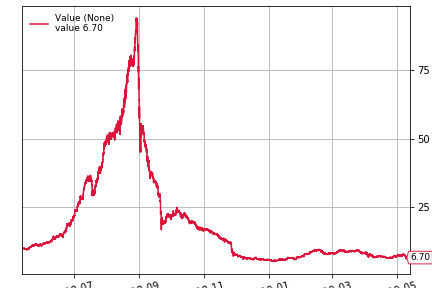

[[<Figure size 432x288 with 1 Axes>]]

In [115]:
cerebro.plot()

In [110]:
results[0].analyzers.sharperatio.get_analysis()

OrderedDict([('sharperatio', 1.0895563899420004)])

In [111]:
results[0].analyzers.returns.get_analysis()

OrderedDict([('rtot', 1.7457737684583157),
             ('ravg', 0.004769873684312338),
             ('rnorm', 2.3267909758487137),
             ('rnorm100', 232.67909758487139)])

In [112]:
results[0].analyzers.drawdown.get_analysis()

AutoOrderedDict([('len', 12328),
                 ('drawdown', 98.01218483009234),
                 ('moneydown', 2825.4263042819475),
                 ('max',
                  AutoOrderedDict([('len', 12328),
                                   ('drawdown', 98.9475713020389),
                                   ('moneydown', 2852.3909673704075)]))])

In [146]:
tickers

['MMM',
 'ABT',
 'ABBV',
 'ABMD',
 'ACN',
 'ATVI',
 'ADBE',
 'AMD',
 'AAP',
 'AES',
 'AMG',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALXN',
 'ALGN',
 'ALLE',
 'AGN',
 'ADS',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'APC',
 'ADI',
 'ANSS',
 'ANTM',
 'AON',
 'AOS',
 'APA',
 'AIV',
 'AAPL',
 'AMAT',
 'APTV',
 'ADM',
 'ARNC',
 'ANET',
 'AJG',
 'AIZ',
 'ATO',
 'T',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'BHGE',
 'BLL',
 'BAC',
 'BK',
 'BAX',
 'BBT',
 'BDX',
 'BRK.B',
 'BBY',
 'BIIB',
 'BLK',
 'HRB',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BF.B',
 'CHRW',
 'COG',
 'CDNS',
 'CPB',
 'COF',
 'CPRI',
 'CAH',
 'KMX',
 'CCL',
 'CAT',
 'CBOE',
 'CBRE',
 'CBS',
 'CE',
 'CELG',
 'CNC',
 'CNP',
 'CTL',
 'CERN',
 'CF',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'XEC',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CTXS',
 'CLX',
 'CME',
 'CMS